# Paralelization for gradient-free optimizers: Differential Evolution
In this notebook, a more complex example is aimed. Here, a differential evolution optimization will be performed employing the vQPUs as accelerators of the quantum task of which the parameters are updated.

As in the rest of the examples, all the imports are done and the vQPUs are raised. After this, they are brought to the program workflow in form of `QPU` instances.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import entropy, norm
from scipy.optimize import differential_evolution

sys.path.append(os.getenv("HOME"))

from cunqa.circuit import CunqaCircuit
from cunqa import get_QPUs, qraise, qdrop
from cunqa.qpu import run 
from cunqa.mappers import QJobMapper, QPUCircuitMapper

family = qraise(10, "00:20:00", simulator = "Aer",  co_located = True)
qpus  = get_QPUs(co_located = True, family = family)

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend['name']}, simulator: {q.backend['simulator']}, version: {q.backend['version']}.")

Requested QPUs with command:
	qraise -n 10 -t 00:20:00 --simulator=Aer --co-located
QPUs ready to work ✅
QPU 377561_2384905, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384906, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384907, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384908, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384909, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384910, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384911, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384912, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384913, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377561_2384914, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.


In this example, the same ansatz, target distribution and distribution divergence measure is defined as in the parameters update feature example. 

In [2]:
def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = CunqaCircuit(num_qubits)
    for p_id in range(num_layers):
        for qubit in range(num_qubits):
            qc.ry(f"phi_{p_id}_{qubit}", qubit)
            qc.rz(f"lam_{p_id}_{qubit}", qubit)
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence

num_qubits = 6
num_layers = 3
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)
num_params = 2 * num_qubits * num_layers

pop = [
    [random.uniform(-math.pi, math.pi) for _ in range(num_params)]
    for _ in range(num_params)
]
bounds=[(-np.pi,np.pi) for _ in range(num_params)]

What changes is the cost function, that in this case will be the following.

In [3]:
def cost_function(result):
    target_dist = target_distribution(num_qubits)
    counts = result.counts
    
    return KL_divergence(counts, 1000, target_dist)

Now, similar to the previous example, a `make_callback` function is defined in order to generate a callback function tailored to the mapper employed.

In [4]:
def make_callback(mapper):
    i = 0
    
    best_individual = []
    energies = []
    def callback(xk, convergence = 1e-8):
        nonlocal i
        best_individual.append(xk)
        energy = mapper(cost_function, [xk])[0]
        energies.append(energy)
        i += 1

    return callback, energies

## QJobMapper
After all the previous steps, the optimization is ready to be performed. In this case, the mapper employed will be `QJobMapper`. This mapper takes a set of `QJobs` and uses the parameter update feature in each iteration.

In [5]:
init_qjobs = []
for i in range(1 * num_params): # we set pop=1 as the population size is pop*num_params
    qpu = qpus[i%len(qpus)] # we select the qpu
    init_qjobs.append(run(ansatz, qpu, [0.0 for _ in range(num_params)], shots=1000))

mapper = QJobMapper(init_qjobs)

callback1, energies1 = make_callback(mapper)
result1 = differential_evolution(cost_function, 
                                bounds, 
                                maxiter = 1000, 
                                workers = mapper, 
                                updating = 'deferred',
                                strategy = 'best1bin',
                                init = pop, 
                                polish = False, 
                                callback=callback1
                               )

In [6]:
print(result1)

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.20667795823664736
                   x: [-1.802e-01 -1.348e+00 ... -1.992e+00  3.043e-01]
                 nit: 1000
                nfev: 36036
          population: [[-1.802e-01 -1.348e+00 ... -1.992e+00  3.043e-01]
                       [ 1.073e+00 -1.708e+00 ... -1.075e+00  9.150e-01]
                       ...
                       [ 1.922e+00  7.773e-01 ... -1.187e+00 -1.805e+00]
                       [-7.132e-01  4.087e-01 ... -1.815e+00  2.353e-01]]
 population_energies: [ 2.067e-01  2.392e-01 ...  2.599e-01  2.871e-01]


## QPUCircuitMapper
In this case, instead of using the parameter update feature, it creates a circuit each time the mapper is called. But, as it can be seen, the employment of this mapper and the previous one is analogous.

In [7]:
mapper = QPUCircuitMapper(qpus, ansatz, shots=1000)

callback2, energies2 = make_callback(mapper)
result2 = differential_evolution(cost_function, 
                                bounds, 
                                maxiter = 1000, 
                                workers = mapper, 
                                updating = 'deferred',
                                strategy = 'best1bin', 
                                init = pop, 
                                polish = False, 
                                callback=callback2
                               )

In [8]:
print(result2)

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.15722812798087116
                   x: [ 2.837e-01 -2.515e+00 ...  1.825e+00  2.464e+00]
                 nit: 1000
                nfev: 36036
          population: [[ 2.837e-01 -2.515e+00 ...  1.825e+00  2.464e+00]
                       [-1.629e-01 -2.074e+00 ...  1.720e+00  1.163e+00]
                       ...
                       [-5.258e-01 -3.135e+00 ...  1.901e+00  2.088e+00]
                       [-1.350e+00 -2.727e+00 ...  1.458e+00  2.012e+00]]
 population_energies: [ 1.572e-01  2.595e-01 ...  2.511e-01  2.468e-01]


### Comparison between QJobMapper and QPUCircuitMapper

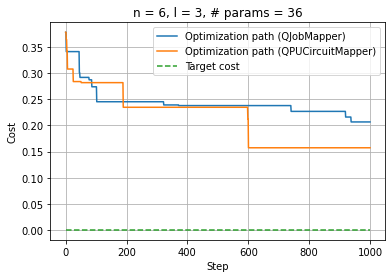

Removed job(s) with ID(s): 377561 


In [9]:
%matplotlib inline
plt.clf()
plt.plot(np.linspace(0, result1.nit, result1.nit), energies1, label="Optimization path (QJobMapper)")
upper_bound = result1.nit
plt.plot(np.linspace(0, result2.nit, result2.nit), energies2, label="Optimization path (QPUCircuitMapper)")
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost");
plt.legend(loc="upper right");
plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_params}")
plt.grid(True)
plt.show()

qdrop(family)

In [10]:
# TODO: Paralelization of expectation value terms

In [11]:
# TODO: Paralelization for gradient optimizers